In [1]:
%matplotlib inline

import json
from typing import List

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.pylabtools import figsize

In [2]:
sns.__version__

'0.11.2'

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
figsize(15, 9)
figsize(15, 9)

In [5]:
with open("results.json", "r") as istream:
    stats = json.load(istream)

In [6]:
rows = []
for name, history in stats.items():
    for g in history:
        rows.append({"guesses": g, "strategy": name})
df = pd.DataFrame(rows)

df.head()

,guesses,strategy
0,13301,StrategyRandomWithReplacement
1,6178,StrategyRandomWithReplacement
2,52000,StrategyRandomWithReplacement
3,7494,StrategyRandomWithReplacement
4,23981,StrategyRandomWithReplacement


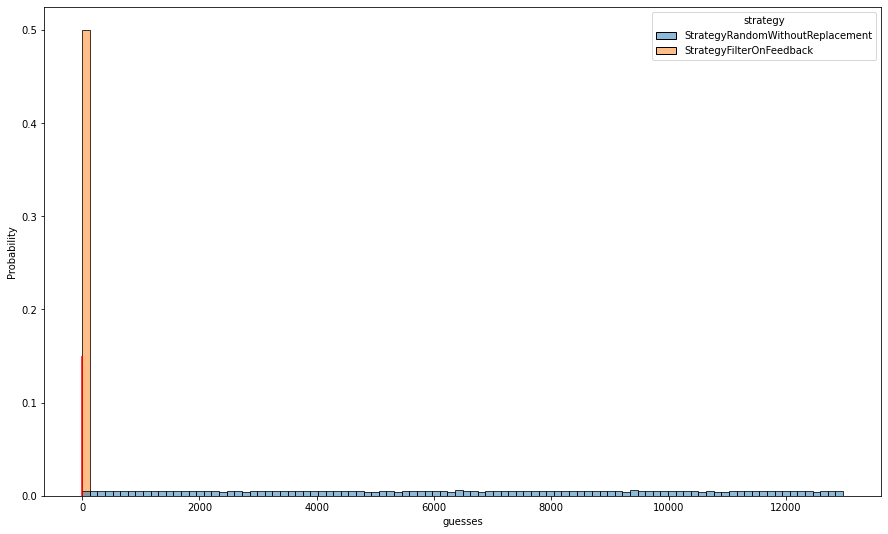

In [18]:
ignored_strategies = [
    'StrategyRandomWithReplacement',
#     'StrategyRandomWithoutReplacement',
]
sns.histplot(
    x="guesses",
    hue="strategy",
    data=df[~df['strategy'].isin(ignored_strategies)],
    bins=100,
    stat='probability',
)
plt.vlines(6, 0, 0.15, color='r')
plt.show()